In [1]:
import tensorflow as tf
from tqdm import trange
import sys
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from time import time
import datetime

from models.tfkeras_resnets import build_resnet, get_resnet_build_function, build_single_block_resnet, get_single_block_resnet_build_function
from dataset_utils.tf_dataset_preprocessors_image_classification import *
from dataset_utils.tfrecord_dataset_creator import TFRecordDatasetCreator, get_tfrecord_paths
from dataset_utils.cifar10_utils import build_cifar10_dataset
from dataset_utils.tf_dataset_creator_from_arrays import create_tf_dataset_from_arrays
from training.training import Training

%matplotlib inline

In [2]:
num_classes = 10
image_shape = (32, 32, 3)
num_layers = 64
final_time = 8
h = final_time / num_layers
num_filters = 8
kernel_type = 'regular'
model_name = 'single_block_{}_{}-layers_{}-filters'.format(kernel_type, num_layers, num_filters)

In [3]:
#load_weights_h5_path = './local/models/weights_single_block_regular_64-layers_16-filters_100-steps.h5'
global_step = 0

In [3]:
cifar10_directory = '/pierluigiferrari/datasets/CIFAR-10_Python/'

train_images, train_labels, val_images, val_labels, label_names = build_cifar10_dataset(cifar10_directory)

In [4]:
cifar10_directory = '/pierluigiferrari/datasets/CIFAR-10_Python/'

train_images, train_labels, val_images, val_labels, label_names = build_cifar10_dataset(cifar10_directory)

batch_size = 32
prefetch = 10

convert_labels_to_one_hot = ConvertLabelsToOneHot(num_classes=10)

preprocessors = [convert_labels_to_one_hot]

(train_dataset,
 train_features_placeholder,
 train_labels_placeholder) = create_tf_dataset_from_arrays(features=train_images,
                                                           labels=train_labels,
                                                           batch_size=batch_size,
                                                           preprocessors=preprocessors,
                                                           repeat=True,
                                                           num_epochs=None,
                                                           shuffle=True,
                                                           prefetch=prefetch)

(val_dataset,
 val_features_placeholder,
 val_labels_placeholder) = create_tf_dataset_from_arrays(features=val_images,
                                                         labels=val_labels,
                                                         batch_size=batch_size,
                                                         preprocessors=preprocessors,
                                                         repeat=True,
                                                         num_epochs=None,
                                                         shuffle=True,
                                                         prefetch=prefetch)

In [5]:
model_build_function = get_single_block_resnet_build_function(kernel_type=kernel_type,
                                                              kernel_size=3,
                                                              h=h,
                                                              num_stages=2,
                                                              blocks_per_stage=[num_layers],
                                                              filters_per_block=[num_filters],
                                                              strides=[(1,1)],
                                                              include_top=True,
                                                              fc_activation='softmax',
                                                              num_classes=num_classes,
                                                              use_batch_norm=False,
                                                              use_max_pooling=[False, False, False, False],
                                                              l2_regularization=0.0,
                                                              subtract_mean=127.5,
                                                              divide_by_stddev=127.5,
                                                              verbose=True)

learning_rate_placeholder = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate_placeholder')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder, epsilon=1e-07)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD()

In [6]:
start_time = time()
trainer = Training(model_build_function=model_build_function,
                   kernel_type=kernel_type,
                   optimizer=optimizer,
                   learning_rate_placeholder=learning_rate_placeholder,
                   train_dataset=train_dataset,
                   val_dataset=val_dataset,
                   dataset_type='arrays',
                   train_features_placeholder=train_features_placeholder,
                   train_labels_placeholder=train_labels_placeholder,
                   val_features_placeholder=val_features_placeholder,
                   val_labels_placeholder=val_labels_placeholder,
                   train_features=train_images,
                   train_labels=train_labels,
                   val_features=val_images,
                   val_labels=val_labels,
                   global_step=global_step,
                   num_layers=num_layers,
                   record_summaries=True,
                   summaries=['mean_gradient_norms'],
                   summaries_dir='./local/tensorboard_summaries',
                   summaries_name=model_name,
                   csv_logger_dir='./local/csv_logger',
                   csv_logger_name='gradient_history')
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

TensorFlow Version: 1.12.0
Building stage 1
Building identity block 2-1
Building identity block 2-2
Building identity block 2-3
Building identity block 2-4
Building identity block 2-5
Building identity block 2-6
Building identity block 2-7
Building identity block 2-8
Building identity block 2-9
Building identity block 2-10
Building identity block 2-11
Building identity block 2-12
Building identity block 2-13
Building identity block 2-14
Building identity block 2-15
Building identity block 2-16
Building identity block 2-17
Building identity block 2-18
Building identity block 2-19
Building identity block 2-20
Building identity block 2-21
Building identity block 2-22
Building identity block 2-23
Building identity block 2-24
Building identity block 2-25
Building identity block 2-26
Building identity block 2-27
Building identity block 2-28
Building identity block 2-29
Building identity block 2-30
Building identity block 2-31
Building identity block 2-32
Building identity block 2-33
Building

In [7]:
start_time = time()
trainer.model.load_weights(load_weights_h5_path)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Total time elapsed: 0:00:00 (h:m:s)


In [8]:
start_time = time()
trainer.train(epochs=20,
              steps_per_epoch=(50000+batch_size-1)//batch_size,
              learning_rate_schedule=lambda x: 0.001,
              eval_dataset='val',
              eval_frequency=1,
              eval_steps=(10000+batch_size-1)//batch_size,
              save_during_training=False,
              save_dir=None,
              save_best_only=True,
              save_tags=['default'],
              save_name='',
              save_frequency=5,
              saver='train_saver',
              monitor='loss',
              summaries_frequency=10)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Default GPU Device: /device:GPU:0
Evaluation on validation dataset: 100%|██████████| 313/313 [00:03<00:00, 59.14it/s, mean_loss=1.4, accuracy=0.487] 
Total time elapsed: 0:20:08 (h:m:s)


In [9]:
save_weights_h5_path = './local/models/weights_{}_{}-steps_eval-loss-{:.2f}_eval-accuracy-{:.3f}.h5'.format(model_name, trainer.g_step, trainer.metric_values[0], trainer.metric_values[1])

In [10]:
trainer.model.save_weights(save_weights_h5_path)

In [4]:
model = build_single_block_resnet(image_shape=image_shape,
                                  kernel_type=kernel_type,
                                  kernel_size=3,
                                  h=h,
                                  num_stages=2,
                                  blocks_per_stage=[num_layers],
                                  filters_per_block=[num_filters],
                                  strides=[(1,1)],
                                  include_top=True,
                                  fc_activation='softmax',
                                  num_classes=num_classes,
                                  use_batch_norm=False,
                                  use_max_pooling=[False, False, False, False],
                                  l2_regularization=0.0,
                                  subtract_mean=127.5,
                                  divide_by_stddev=127.5,
                                  verbose=True)

Building stage 1
Building identity block 2-1
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.11it/s]
Building identity block 2-2
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 13.50it/s]
Building identity block 2-3
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.89it/s]
Building identity block 2-4
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.08it/s]
Building identity block 2-5
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.04it/s]
Building identity block 2-6
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00,  9.79it/s]
Building identity block 2-7
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.94it/s]
Building identity block 2-8
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.25it/s]
Building identity block 2-9
Bui

In [5]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
#model.load_weights(load_weights_h5_path)

In [6]:
start_time = time()
history = model.fit(x=train_images[:6400],
                    y=tf.keras.utils.to_categorical(train_labels[:6400], num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=None, #(val_images, tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Epoch 1/1
6400/6400 [==============================] - 1019s 159ms/step - loss: 3.5780 - acc: 0.1445
Total time elapsed: 0:19:35 (h:m:s)


In [7]:
save_weights_h5_path = './local/models/weights_{}_200-steps.h5'.format(model_name)

In [8]:
model.save_weights(filepath=save_weights_h5_path)

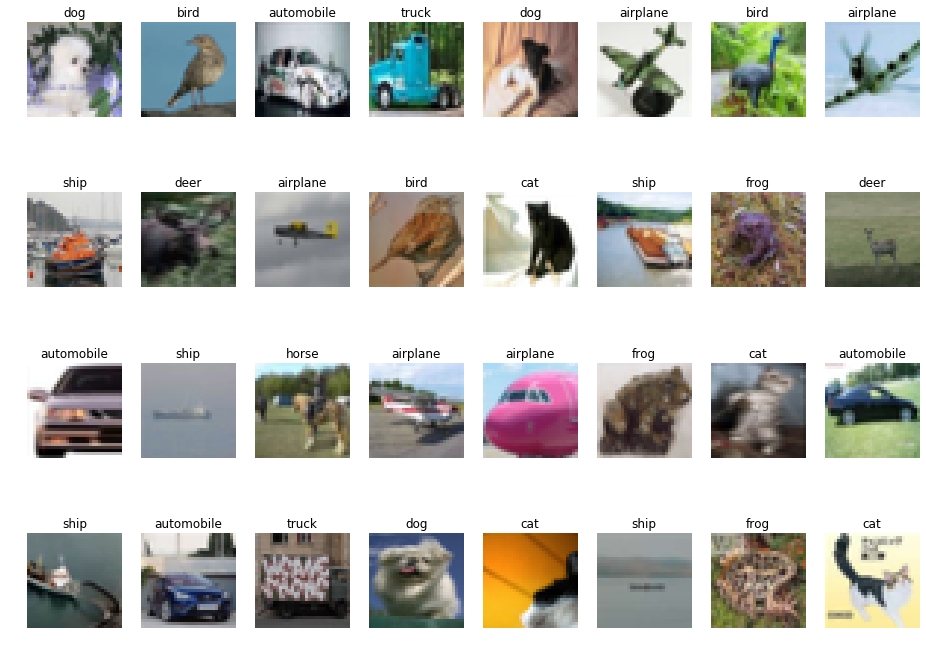

In [3]:
grid_m = 4
grid_n = 8

random_grid = np.random.randint(50000, size=[grid_m, grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(16,12))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(train_images[random_grid[i,j]].astype(np.uint8))
        cell0[i, j].axis('off')
        cell0[i, j].set_title(label_names[train_labels[random_grid[i,j]]])

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class TrainingHistory:
    
    def __init__(self,
                 training_history_filepath=None,
                 evaluation_history_filepath=None,
                 delimiter=' '):
        
        if not training_history_filepath is None:
            
            self.training_steps = []
            self.training_mean_loss = []
            self.training_accuracy = []
            self.gradient_norms = []

            with open(training_history_filepath, 'r') as training_history:
                csv_reader = csv.reader(training_history, delimiter=delimiter)
                self.training_header = next(csv_reader)
                self.gradient_names = self.training_header[3:]
                for row in csv_reader:
                    self.training_steps.append(int(row[0]))
                    self.training_mean_loss.append(float(row[1]))
                    self.training_accuracy.append(float(row[2]))
                    self.gradient_norms.append(np.array(row[3:], dtype=np.float))

            self.training_steps = np.array(self.training_steps)
            self.training_mean_loss = np.array(self.training_mean_loss)
            self.training_accuracy = np.array(self.training_accuracy)
            self.gradient_norms = np.stack(self.gradient_norms, axis=0)

            self.num_time_steps_training, self.num_layers = self.gradient_norms.shape
            
        if not evaluation_history_filepath is None:
            
            self.evaluation_steps = []
            self.evaluation_mean_loss = []
            self.evaluation_accuracy = []

            with open(evaluation_history_filepath, 'r') as evaluation_history:
                csv_reader = csv.reader(evaluation_history, delimiter=delimiter)
                self.evaluation_header = next(csv_reader)
                for row in csv_reader:
                    self.evaluation_steps.append(int(row[0]))
                    self.evaluation_mean_loss.append(float(row[1]))
                    self.evaluation_accuracy.append(float(row[2]))

            self.evaluation_steps = np.array(self.evaluation_steps)
            self.evaluation_mean_loss = np.array(self.evaluation_mean_loss)
            self.evaluation_accuracy = np.array(self.evaluation_accuracy)

            self.num_time_steps_evaluation = len(self.evaluation_steps)
        
    def plot_mean_loss(self,
                       data='both',
                       figsize=(20,10),
                       step_bounds_training=(None, None, None),
                       step_bounds_evaluation=(None, None, None),
                       line_color_training='rosybrown',
                       line_color_evaluation='rosybrown',
                       line_width=3.0,
                       x_ticks=None,
                       x_ticks_rotation=0,
                       tick_label_size=18,
                       tick_label_pad=(10, 10),
                       axis_label_size=18,
                       axis_label_pad=(10, 10),
                       axis_labels=['Training steps', 'Mean loss'],
                       show_legend=True,
                       legend_size=18,
                       show_grid=True):
        
        return self._plot_line(plot='mean_loss',
                            data=data,
                            figsize=figsize,
                            step_bounds_training=step_bounds_training,
                            step_bounds_evaluation=step_bounds_evaluation,
                            line_color_training=line_color_training,
                            line_color_evaluation=line_color_evaluation,
                            line_width=line_width,
                            x_ticks=x_ticks,
                            x_ticks_rotation=x_ticks_rotation,
                            tick_label_size=tick_label_size,
                            tick_label_pad=tick_label_pad,
                            axis_label_size=axis_label_size,
                            axis_label_pad=axis_label_pad,
                            axis_labels=axis_labels,
                            show_legend=show_legend,
                            legend_size=legend_size,
                            show_grid=show_grid)
        
    def plot_accuracy(self,
                      data='both',
                      figsize=(20,10),
                      step_bounds_training=(None, None, None),
                      step_bounds_evaluation=(None, None, None),
                      line_color_training='rosybrown',
                      line_color_evaluation='rosybrown',
                      line_width=3.0,
                      x_ticks=None,
                      x_ticks_rotation=0,
                      tick_label_size=18,
                      tick_label_pad=(10, 10),
                      axis_label_size=18,
                      axis_label_pad=(10, 10),
                      axis_labels=['Training steps', 'Mean loss'],
                      show_legend=True,
                      legend_size=18,
                      show_grid=True):
        
        return self._plot_line(plot='accuracy',
                            data=data,
                            figsize=figsize,
                            step_bounds_training=step_bounds_training,
                            step_bounds_evaluation=step_bounds_evaluation,
                            line_color_training=line_color_training,
                            line_color_evaluation=line_color_evaluation,
                            line_width=line_width,
                            x_ticks=x_ticks,
                            x_ticks_rotation=x_ticks_rotation,
                            tick_label_size=tick_label_size,
                            tick_label_pad=tick_label_pad,
                            axis_label_size=axis_label_size,
                            axis_label_pad=axis_label_pad,
                            axis_labels=axis_labels,
                            show_legend=show_legend,
                            legend_size=legend_size,
                            show_grid=show_grid)
        
    def _plot_line(self,
                   plot=None,
                   data='both',
                   label=None,
                   figsize=(20,10),
                   step_bounds_training=(None, None, None),
                   step_bounds_evaluation=(None, None, None),
                   line_color_training='rosybrown',
                   line_color_evaluation='palegoldenrod',
                   line_width=3.0,
                   x_ticks=None,
                   x_ticks_rotation=0,
                   tick_label_size=18,
                   tick_label_pad=(10, 10),
                   axis_label_size=18,
                   axis_label_pad=(10, 10),
                   axis_labels=['Training steps', 'Mean loss'],
                   show_legend=True,
                   legend_size=18,
                   show_grid=True):
        
        figure = plt.figure(figsize=figsize)
        
        if isinstance(data, str):
            
            if data in {'training', 'both'}:

                y_train = self.training_mean_loss if plot == 'mean_loss' else self.training_accuracy
                label_train = 'Training loss' if plot == 'mean_loss' else 'Training accuracy'

                step_start = 0 if (step_bounds_training[0] is None) else step_bounds_training[0]
                step_stop = self.num_time_steps_training if (step_bounds_training[1] is None) else step_bounds_training[1]
                step_step = 1 if (step_bounds_training[2] is None) else step_bounds_training[2]

                plt.plot(self.training_steps[step_start:step_stop:step_step],
                         y_train[step_start:step_stop:step_step],
                         linewidth=line_width,
                         color=line_color_training,
                         label=label_train)

            if data in {'evaluation', 'both'}:

                y_val = self.evaluation_mean_loss if plot == 'mean_loss' else self.evaluation_accuracy
                label_val = 'Validation loss' if plot == 'mean_loss' else 'Validation accuracy'

                step_start = 0 if (step_bounds_evaluation[0] is None) else step_bounds_evaluation[0]
                step_stop = self.num_time_steps_evaluation if (step_bounds_evaluation[1] is None) else step_bounds_evaluation[1]
                step_step = 1 if (step_bounds_evaluation[2] is None) else step_bounds_evaluation[2]

                plt.plot(self.evaluation_steps[step_start:step_stop:step_step],
                         y_val[step_start:step_stop:step_step],
                         linewidth=line_width,
                         color=line_color_evaluation,
                         label=label_val)
                
        elif isinstance(data, (list, tuple)):
            
            plt.plot(data[0],
                     data[1],
                     linewidth=line_width,
                     color=line_color_training,
                     label=label)
            
        if show_legend:
            plt.legend(fontsize=legend_size)
        
        # Format the axes and their labels.
        plt.xlabel(axis_labels[0], labelpad=axis_label_pad[0], fontsize=axis_label_size)
        plt.ylabel(axis_labels[1], labelpad=axis_label_pad[1], fontsize=axis_label_size)
        plt.grid(show_grid)
        axes = plt.gca()
        if not x_ticks is None:
            x_start = 0 if (x_ticks[0] is None) else x_ticks[0]
            x_stop = self.num_time_steps_training if (x_ticks[1] is None) else x_ticks[1]
            x_step = 1 if (x_ticks[2] is None) else x_ticks[2]
            axes.set_xticks(ticks=self.training_steps[x_start:x_stop:x_step])
        axes.tick_params(axis='x', which='major', labelsize=tick_label_size, pad=tick_label_pad[0], rotation=x_ticks_rotation)
        axes.tick_params(axis='y', which='major', labelsize=tick_label_size, pad=tick_label_pad[1])
        
        return figure, axes
        
    def plot_gradient_norms(self,
                            layer_bounds=(1, None, 2),
                            step_bounds=(1, None, 100),
                            z_axis_bounds=(None, None),
                            plot_type='surface',
                            figsize=(18, 10),
                            axis_labels=('Layer', 'Step', 'Mean norm'),
                            tick_label_font_size=16,
                            axis_label_font_size=16,
                            tick_label_pad=(10, 10, 20),
                            axis_label_pad=(18, 28, 18),
                            color_map=cm.pink,
                            color_bar=True,
                            color_bar_tick_label_size=16):
        
        layer_start = 0 if (layer_bounds[0] is None) else layer_bounds[0]
        layer_stop = self.num_layers if (layer_bounds[1] is None) else layer_bounds[1]
        layer_step = 1 if (layer_bounds[2] is None) else layer_bounds[2]
        
        step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
        step_stop = self.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
        step_step = 1 if (step_bounds[2] is None) else step_bounds[2]
        
        # Build the plot grid.
        layers = np.arange(layer_start + 1, layer_stop + 1, layer_step)
        steps = self.training_steps[step_start:step_stop:step_step]
        layers_grid, steps_grid = np.meshgrid(layers, steps)
        gradient_norms = self.gradient_norms[step_start:step_stop:step_step, layer_start:layer_stop:layer_step]
        
        # Create the plot.
        figure = plt.figure(figsize=figsize)
        axes = Axes3D(figure)
        if plot_type == 'wireframe':
            plot = axes.plot_wireframe(layers_grid, steps_grid, gradient_norms, rstride=1, cstride=1)
        elif plot_type == 'surface':
            plot = axes.plot_surface(layers_grid, steps_grid, gradient_norms, rstride=1, cstride=1, cmap=color_map, antialiased=True)
        else:
            raise ValueError("Unsupported plot_type. You passed '{}', but supported plot_types are 'surface' and 'wireframe'.".format(plot_type))
        
        # Customize the axes.
        axes.set_zlim3d(z_axis_bounds[0], z_axis_bounds[1])
        axes.xaxis.set_tick_params(labelsize=tick_label_font_size, pad=tick_label_pad[0])
        axes.yaxis.set_tick_params(labelsize=tick_label_font_size, pad=tick_label_pad[1])
        axes.zaxis.set_tick_params(labelsize=tick_label_font_size, pad=tick_label_pad[2])
        axes.set_xlabel(axis_labels[0], labelpad=tick_label_pad[0]+axis_label_pad[0], fontsize=axis_label_font_size)
        axes.set_ylabel(axis_labels[1], labelpad=tick_label_pad[1]+axis_label_pad[1], fontsize=axis_label_font_size)
        axes.set_zlabel(axis_labels[2], labelpad=tick_label_pad[2]+axis_label_pad[2], fontsize=axis_label_font_size)
        
        if plot_type == 'surface' and color_bar:
            cbar = figure.colorbar(plot, shrink=0.5, aspect=10)
            cbar.ax.tick_params(labelsize=color_bar_tick_label_size) 
        
        return plot, axes, figure
    
    def gradient_norm_relative_deviation(self,
                                         reduce=True,
                                         layer_bounds=(1, None, None),
                                         step_bounds=(None, None, 100)):
        
        layer_start = 0 if (layer_bounds[0] is None) else layer_bounds[0]
        layer_stop = self.num_layers if (layer_bounds[1] is None) else layer_bounds[1]
        layer_step = 1 if (layer_bounds[2] is None) else layer_bounds[2]
        
        axis = None if reduce else 1
        
        means = np.mean(self.gradient_norms[:,layer_start:layer_stop:layer_step], axis=1)
        deviations = np.power(self.gradient_norms[:,layer_start:layer_stop:layer_step] / means[:, None], 2)
        reduced = np.sqrt(np.average(deviations, axis=axis))
        
        if reduce:
            return reduced
        else:
            step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
            step_stop = self.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
            step_step = 1 if (step_bounds[2] is None) else step_bounds[2]
            return reduced[step_start:step_stop:step_step]
        
    def gradient_norm_standard_deviation(self,
                                         reduce=True,
                                         layer_bounds=(1, None, 2),
                                         step_bounds=(None, None, 100)):
        
        layer_start = 0 if (layer_bounds[0] is None) else layer_bounds[0]
        layer_stop = self.num_layers if (layer_bounds[1] is None) else layer_bounds[1]
        layer_step = 1 if (layer_bounds[2] is None) else layer_bounds[2]
        
        standard_deviations = np.std(self.gradient_norms[:,layer_start:layer_stop:layer_step], axis=1)
        
        if reduce:
            return np.average(standard_deviations)
        else:
            step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
            step_stop = self.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
            step_step = 1 if (step_bounds[2] is None) else step_bounds[2]
            return standard_deviations[step_start:step_stop:step_step]
        
    def gradient_norm_relative_comparison(self,
                                          reduce=True,
                                          last=-1,
                                          first=0,
                                          step_bounds=(None, None, 100)):
        
        step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
        step_stop = self.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
        step_step = 1 if (step_bounds[2] is None) else step_bounds[2]
        
        relative = self.gradient_norms[step_start:step_stop:step_step, last] / self.gradient_norms[step_start:step_stop:step_step, first]
        
        if reduce:
            return np.average(relative)
        else:
            return relative
        
    def plot_gradient_norm_relative_deviation(self,
                                              figsize=(20,10),
                                              layer_bounds=(1, None, None),
                                              step_bounds=(None, None, 100),
                                              label='Gradient norm relative deviation',
                                              line_color='rosybrown',
                                              line_width=3.0,
                                              x_ticks=None,
                                              x_ticks_rotation=0,
                                              tick_label_size=18,
                                              tick_label_pad=(10, 10),
                                              axis_label_size=18,
                                              axis_label_pad=(10, 10),
                                              axis_labels=['Training steps', 'Mean gradient norm relative deviation'],
                                              show_legend=False,
                                              legend_size=18,
                                              show_grid=True):
        
        gradient_norm_relative_deviation = self.gradient_norm_relative_deviation(reduce=False,
                                                                                 layer_bounds=layer_bounds,
                                                                                 step_bounds=step_bounds)
        
        step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
        step_stop = self.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
        step_step = 1 if (step_bounds[2] is None) else step_bounds[2]
        
        data = [self.training_steps[step_start:step_stop:step_step],
                gradient_norm_relative_deviation]
        
        return self._plot_line(plot=None,
                               data=data,
                               label=label,
                               figsize=figsize,
                               line_color_training=line_color,
                               line_width=line_width,
                               x_ticks=x_ticks,
                               x_ticks_rotation=x_ticks_rotation,
                               tick_label_size=tick_label_size,
                               tick_label_pad=tick_label_pad,
                               axis_label_size=axis_label_size,
                               axis_label_pad=axis_label_pad,
                               axis_labels=axis_labels,
                               show_legend=show_legend,
                               legend_size=legend_size,
                               show_grid=show_grid)
    
def plot_lines(data,
               labels=None,
               line_colors=None,
               figsize=(20,10),
               line_width=3.0,
               x_ticks=None,
               x_ticks_rotation=0,
               tick_label_size=18,
               tick_label_pad=(10, 10),
               axis_label_size=18,
               axis_label_pad=(10, 10),
               axis_labels=['Training steps', 'Data'],
               show_legend=True,
               legend_size=18,
               show_grid=True):
        
        figure = plt.figure(figsize=figsize)
        
        x = data[0]
        
        for i, y in enumerate(data[1:]):
            
            line_color = None if line_colors is None else line_colors[i]
            
            plt.plot(x,
                     y,
                     linewidth=line_width,
                     color=line_color,
                     label=labels[i])
            
        if show_legend:
            plt.legend(fontsize=legend_size)
        
        # Format the axes and their labels.
        if not axis_labels[0] is None:
            plt.xlabel(axis_labels[0], labelpad=axis_label_pad[0], fontsize=axis_label_size)
        if not axis_labels[1] is None:
            plt.ylabel(axis_labels[1], labelpad=axis_label_pad[1], fontsize=axis_label_size)
        plt.grid(show_grid)
        axes = plt.gca()
        if not x_ticks is None:
            axes.set_xticks(ticks=x_ticks)
        axes.tick_params(axis='x', which='major', labelsize=tick_label_size, pad=tick_label_pad[0], rotation=x_ticks_rotation)
        axes.tick_params(axis='y', which='major', labelsize=tick_label_size, pad=tick_label_pad[1])
        
        return figure, axes

In [3]:
anti_16_train_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_antisymmetric_64-layers_16-filters_gradient_history.csv'
regu_16_train_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_regular_64-layers_16-filters_gradient_history.csv'
regu_8_train_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_regular_64-layers_8-filters_gradient_history.csv'

anti_16_eval_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_antisymmetric_64-layers_16-filters_evaluation_metrics.csv'
regu_16_eval_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_regular_64-layers_16-filters_evaluation_metrics.csv'
regu_8_eval_history_filepath = '/pierluigiferrari/git/differential_equations_resnet/numerical_results/csv/single_block_regular_64-layers_8-filters_evaluation_metrics.csv'

anti_16_history = TrainingHistory(training_history_filepath=anti_16_train_history_filepath,
                                  evaluation_history_filepath=anti_16_eval_history_filepath)
regu_16_history = TrainingHistory(training_history_filepath=regu_16_train_history_filepath,
                                  evaluation_history_filepath=regu_16_eval_history_filepath)
regu_8_history = TrainingHistory(training_history_filepath=regu_8_train_history_filepath,
                                  evaluation_history_filepath=regu_8_eval_history_filepath)

# Gradient Norm Relative Deviation

In [4]:
step_bounds = (None, None, None)
layer_bounds = (1, None, None)

anti_16_rel_deviation = anti_16_history.gradient_norm_relative_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)
regu_16_rel_deviation = regu_16_history.gradient_norm_relative_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)
regu_8_rel_deviation = regu_8_history.gradient_norm_relative_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)

print(anti_16_rel_deviation)
print(regu_16_rel_deviation)
print(regu_8_rel_deviation)

1.1399205919985331
1.0606033762953535
1.1015792847576582


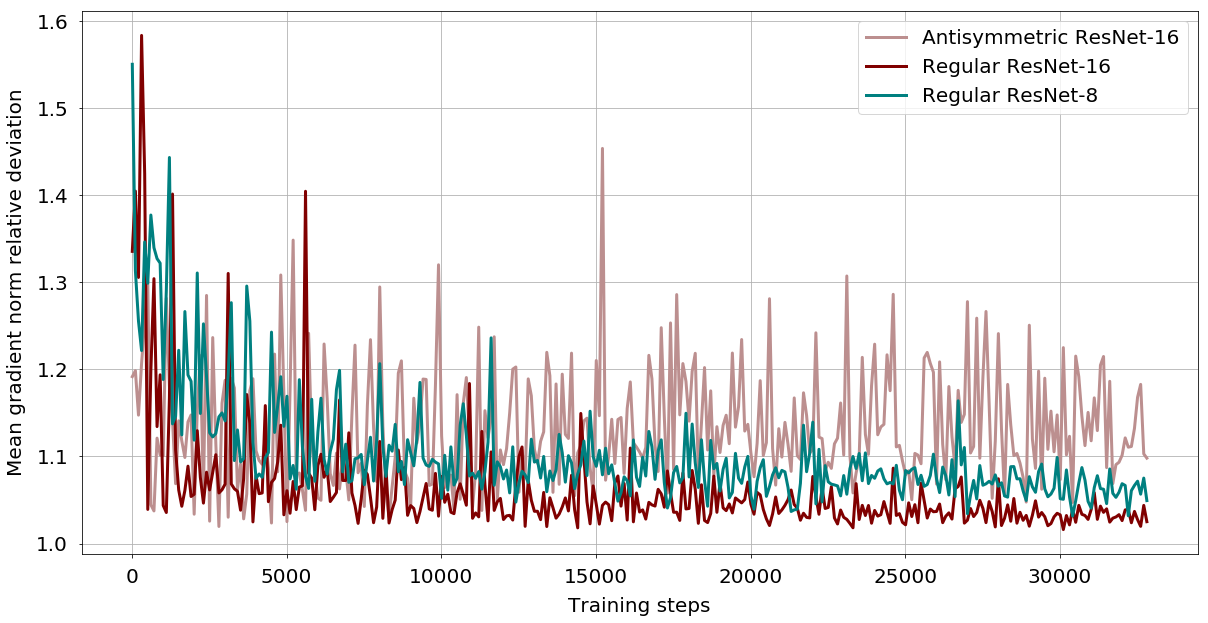

In [213]:
step_bounds = (1, None, 10)
layer_bounds = (1, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.gradient_norm_relative_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)
y2 = regu_16_history.gradient_norm_relative_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)
y3 = regu_8_history.gradient_norm_relative_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)

x = anti_16_history.training_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Mean gradient norm relative deviation'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

In [215]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/mean_gradient_norm_relative_deviation.pdf',
               dpi=150,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

# Gradient Norm Standard Deviation

In [5]:
step_bounds = (None, None, None)
layer_bounds = (1, None, None)

anti_16_st_deviation = anti_16_history.gradient_norm_standard_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)
regu_16_st_deviation = regu_16_history.gradient_norm_standard_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)
regu_8_st_deviation = regu_8_history.gradient_norm_standard_deviation(reduce=True, layer_bounds=layer_bounds, step_bounds=step_bounds)

print('{:f}'.format(anti_16_st_deviation))
print('{:f}'.format(regu_16_st_deviation))
print('{:f}'.format(regu_8_st_deviation))

0.000125
0.000024
0.000151


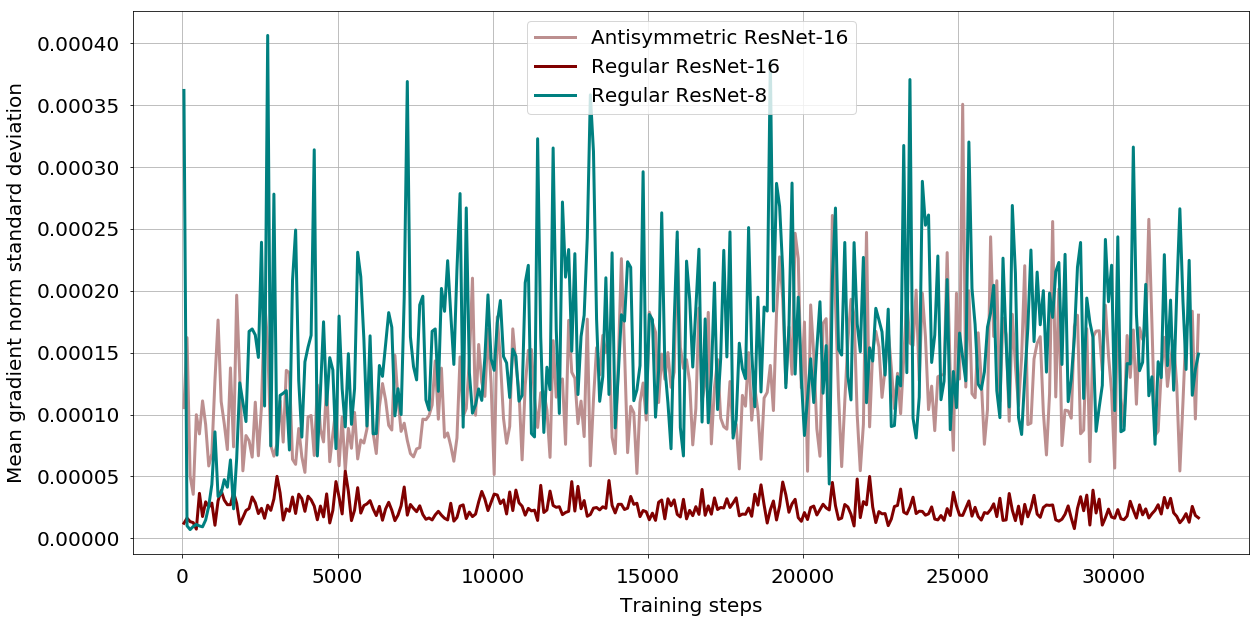

In [218]:
step_bounds = (5, None, 10)
layer_bounds = (1, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.gradient_norm_standard_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)
y2 = regu_16_history.gradient_norm_standard_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)
y3 = regu_8_history.gradient_norm_standard_deviation(reduce=False, layer_bounds=layer_bounds, step_bounds=step_bounds)

x = anti_16_history.training_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Mean gradient norm standard deviation'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

In [219]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/mean_gradient_norm_standard_deviation.pdf',
               dpi=150,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

# Gradient Norm Relative Comparison

In [6]:
step_bounds = (None, None, None)
last = -1
first = 1

anti_16_st_relative = anti_16_history.gradient_norm_relative_comparison(reduce=True, last=last, first=first, step_bounds=step_bounds)
regu_16_st_relative = regu_16_history.gradient_norm_relative_comparison(reduce=True, last=last, first=first, step_bounds=step_bounds)
regu_8_st_relative = regu_8_history.gradient_norm_relative_comparison(reduce=True, last=last, first=first, step_bounds=step_bounds)

print('{:f}'.format(anti_16_st_relative))
print('{:f}'.format(regu_16_st_relative))
print('{:f}'.format(regu_8_st_relative))

2.741706
1.243309
1.427782


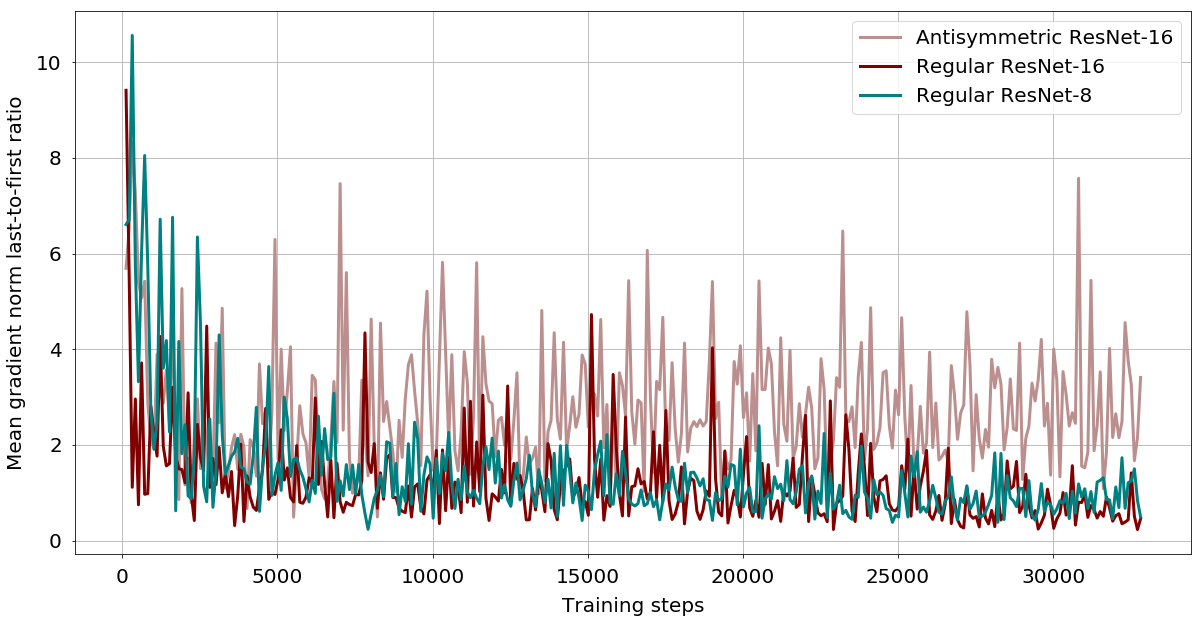

In [224]:
step_bounds = (12, None, 10)
layer_bounds = (1, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.gradient_norm_relative_comparison(reduce=False, last=-1, first=1, step_bounds=step_bounds)
y2 = regu_16_history.gradient_norm_relative_comparison(reduce=False, last=-1, first=1, step_bounds=step_bounds)
y3 = regu_8_history.gradient_norm_relative_comparison(reduce=False, last=-1, first=1, step_bounds=step_bounds)

x = anti_16_history.training_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Mean gradient norm last-to-first ratio'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

In [225]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/mean_gradient_norm_last_first_ratio.pdf',
               dpi=150,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

# Mean Loss and Accuracy

## Best Validation Accuracy

In [226]:
anti_16_best_evaluation_accuracy = np.amax(anti_16_history.evaluation_accuracy)
regu_16_best_evaluation_accuracy = np.amax(regu_16_history.evaluation_accuracy)
regu_8_best_evaluation_accuracy = np.amax(regu_8_history.evaluation_accuracy)

print('{:f}'.format(anti_16_best_evaluation_accuracy))
print('{:f}'.format(regu_16_best_evaluation_accuracy))
print('{:f}'.format(regu_8_best_evaluation_accuracy))

0.552584
0.604668
0.495393


## Validation Accuracy

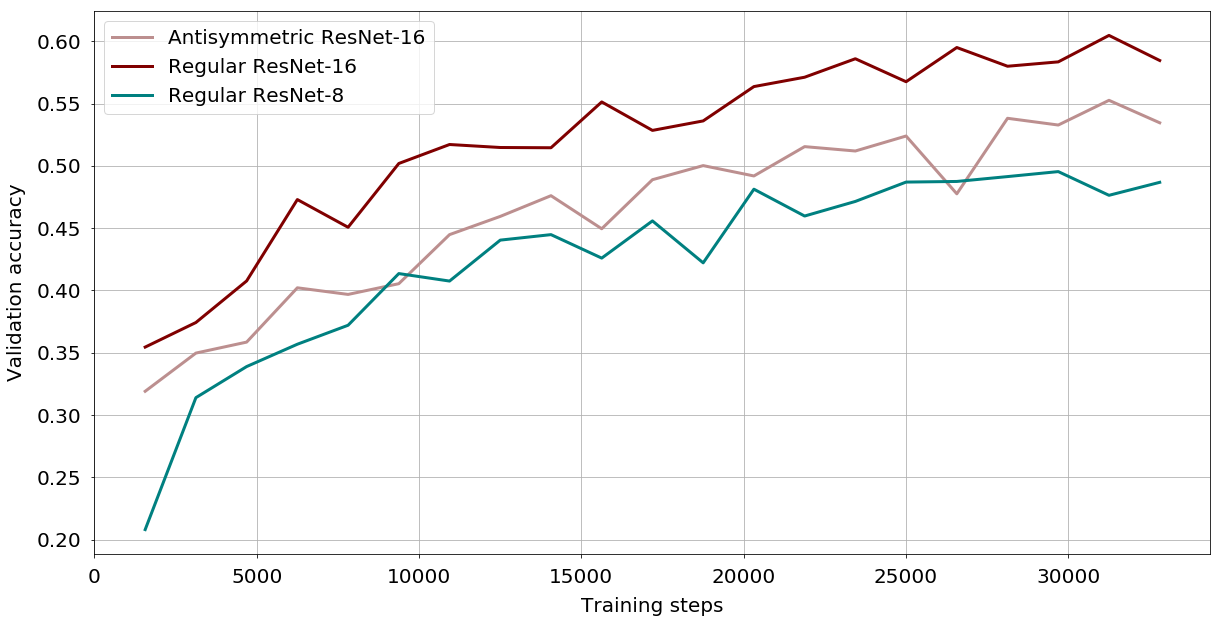

In [10]:
step_bounds = (None, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_evaluation if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.evaluation_accuracy[step_start:step_stop:step_step]
y2 = regu_16_history.evaluation_accuracy[step_start:step_stop:step_step]
y3 = regu_8_history.evaluation_accuracy[step_start:step_stop:step_step]
x = anti_16_history.evaluation_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Validation accuracy'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

In [11]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/validation_accuracy.pdf',
               dpi=150,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Validation Mean Loss

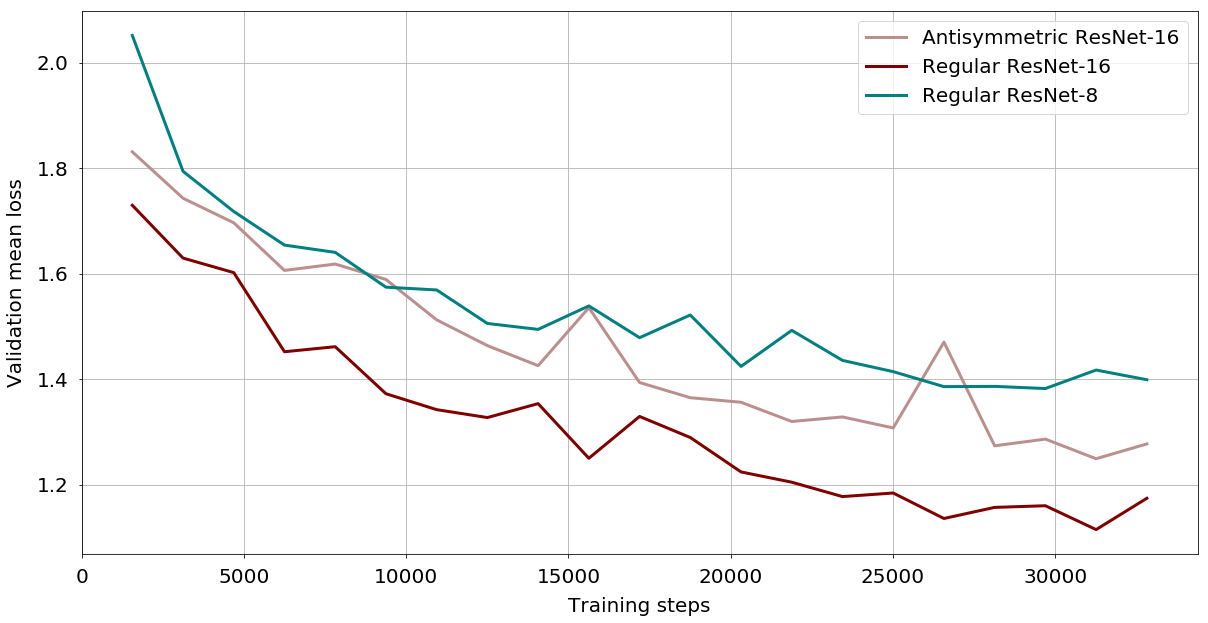

In [14]:
step_bounds = (None, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_evaluation if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.evaluation_mean_loss[step_start:step_stop:step_step]
y2 = regu_16_history.evaluation_mean_loss[step_start:step_stop:step_step]
y3 = regu_8_history.evaluation_mean_loss[step_start:step_stop:step_step]
x = anti_16_history.evaluation_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Validation mean loss'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

In [15]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/validation_mean_loss.pdf',
               dpi=150,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Training Accuracy

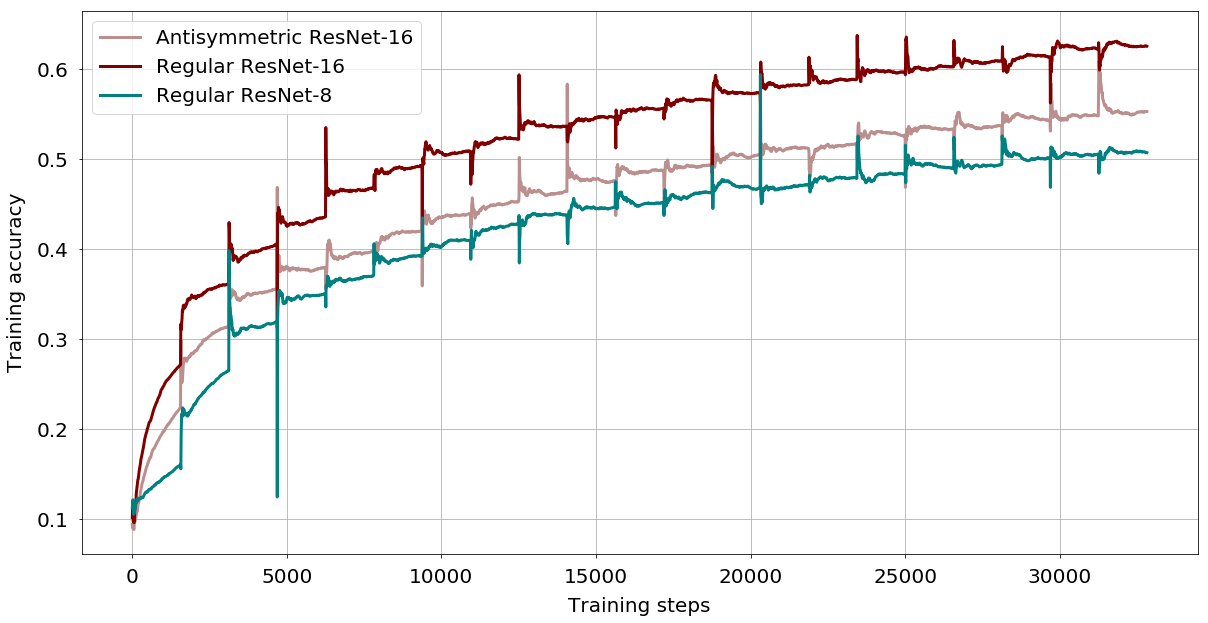

In [17]:
step_bounds = (None, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.training_accuracy[step_start:step_stop:step_step]
y2 = regu_16_history.training_accuracy[step_start:step_stop:step_step]
y3 = regu_8_history.training_accuracy[step_start:step_stop:step_step]
x = anti_16_history.training_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Training accuracy'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

## Training Mean Loss

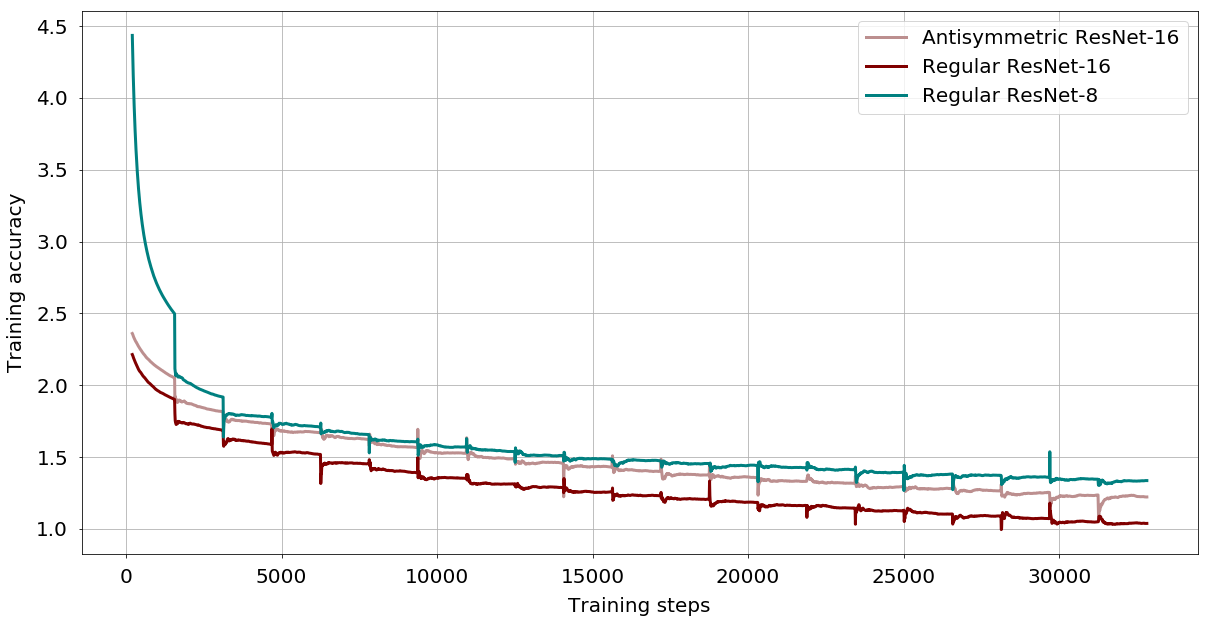

In [23]:
step_bounds = (20, None, None)

step_start = 0 if (step_bounds[0] is None) else step_bounds[0]
step_stop = anti_16_history.num_time_steps_training if (step_bounds[1] is None) else step_bounds[1]
step_step = 1 if (step_bounds[2] is None) else step_bounds[2]

y1 = anti_16_history.training_mean_loss[step_start:step_stop:step_step]
y2 = regu_16_history.training_mean_loss[step_start:step_stop:step_step]
y3 = regu_8_history.training_mean_loss[step_start:step_stop:step_step]
x = anti_16_history.training_steps[step_start:step_stop:step_step]

figure, axes = plot_lines(data=[x, y1, y2, y3],
                          labels=['Antisymmetric ResNet-16', 'Regular ResNet-16', 'Regular ResNet-8'],
                          line_colors=['rosybrown', 'maroon', 'teal'],
                           figsize=(20,10),
                           line_width=3.0,
                           x_ticks=None,
                           x_ticks_rotation=0,
                           tick_label_size=20,
                           tick_label_pad=(10, 10),
                           axis_label_size=20,
                           axis_label_pad=(10, 10),
                           axis_labels=['Training steps', 'Training accuracy'],
                           show_legend=True,
                           legend_size=20,
                           show_grid=True)

## Antisymmetric 16

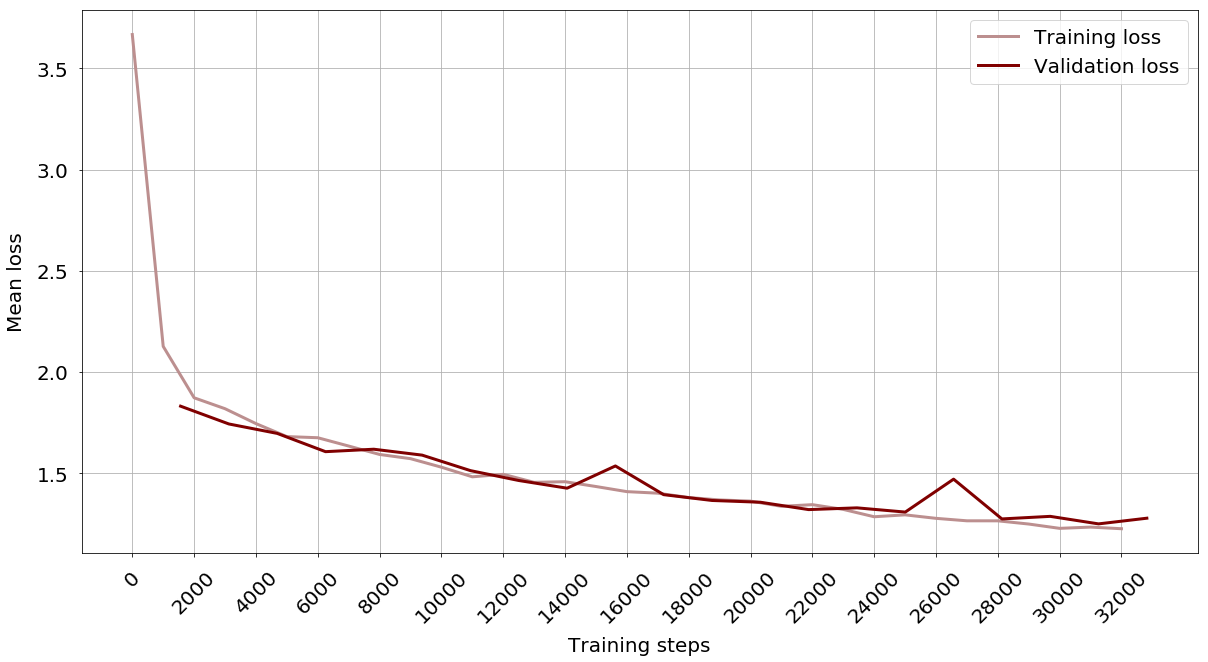

In [228]:
figure, axes = anti_16_history.plot_mean_loss(data='both',
                                              figsize=(20,10),
                                              step_bounds_training=(None, None, 100),
                                              step_bounds_evaluation=(None, None, None),
                                              line_color_training='rosybrown',
                                              line_color_evaluation='maroon',
                                              line_width=3.0,
                                              x_ticks=(None, None, 200),
                                              x_ticks_rotation=45,
                                              tick_label_size=20,
                                              tick_label_pad=(10, 10),
                                              axis_label_size=20,
                                              axis_label_pad=(10, 10),
                                              axis_labels=['Training steps', 'Mean loss'],
                                              show_legend=True,
                                              legend_size=20,
                                              show_grid=True)

In [229]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_antisymmetric_64-layers_16-filters_mean_loss.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

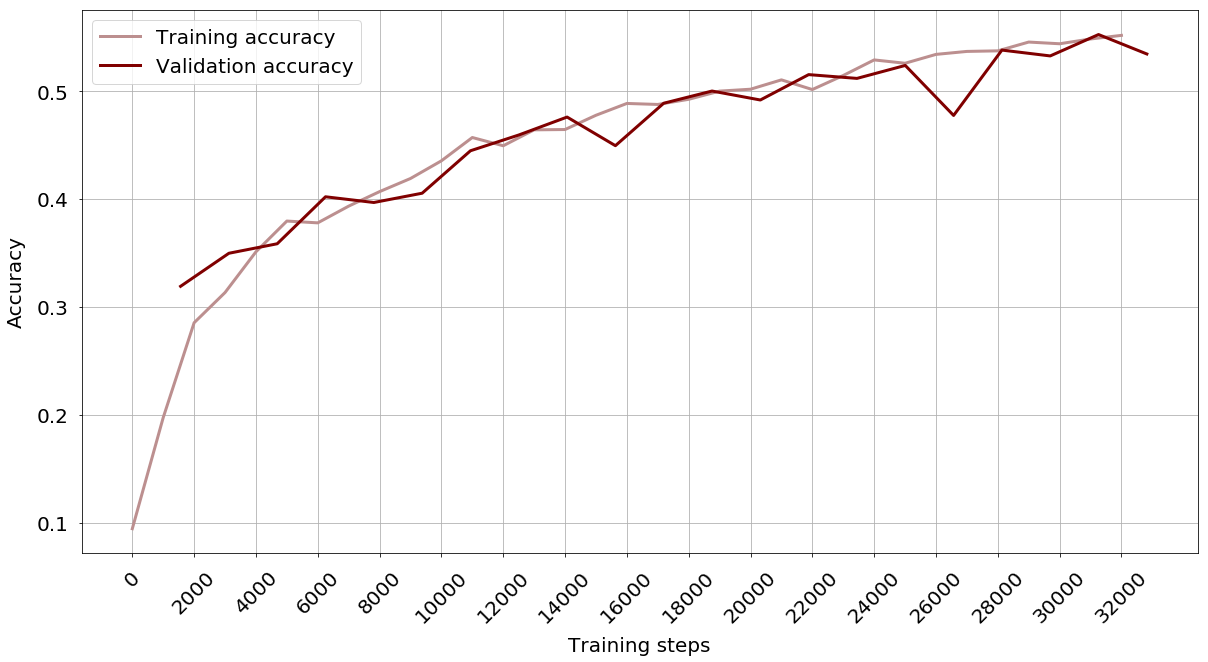

In [230]:
figure, axes = anti_16_history.plot_accuracy(
    data='both',
    figsize=(20,10),
    step_bounds_training=(None, None, 100),
    step_bounds_evaluation=(None, None, None),
    line_color_training='rosybrown',
    line_color_evaluation='maroon',
    line_width=3.0,
    x_ticks=(None, None, 200),
    x_ticks_rotation=45,
    tick_label_size=20,
    tick_label_pad=(10, 10),
    axis_label_size=20,
    axis_label_pad=(10, 10),
    axis_labels=['Training steps', 'Accuracy'],
    show_legend=True,
    legend_size=20,
    show_grid=True
)

In [231]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_antisymmetric_64-layers_16-filters_accuracy.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Regular 16

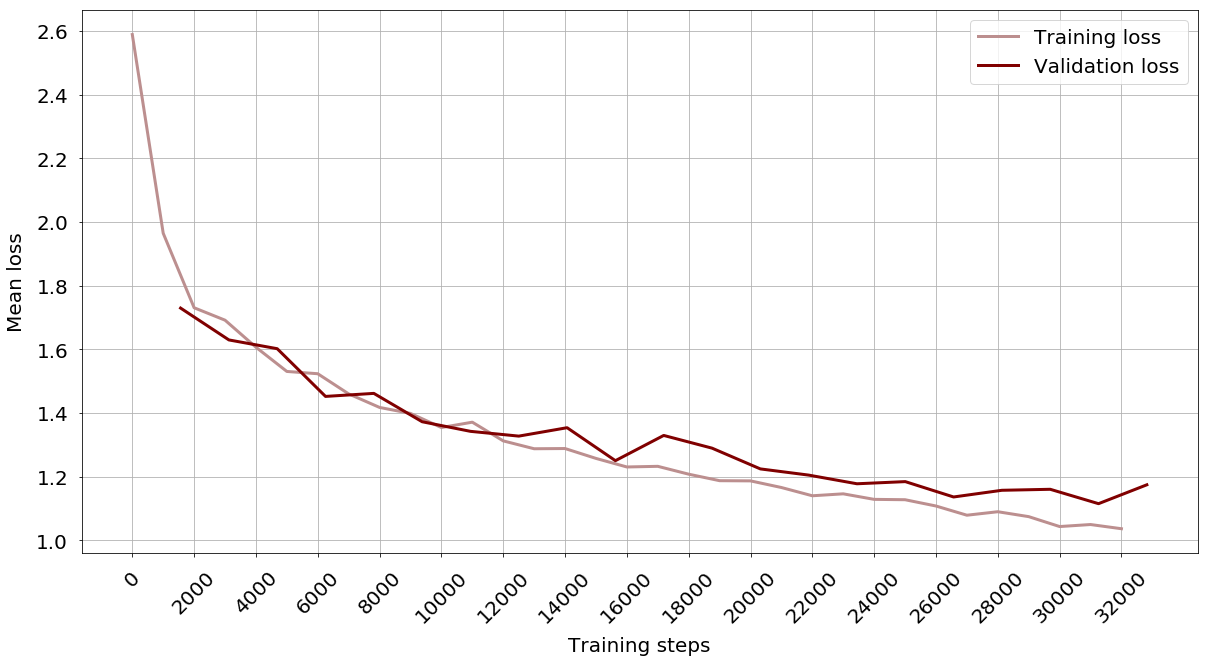

In [232]:
figure, axes = regu_16_history.plot_mean_loss(data='both',
                                              figsize=(20,10),
                                              step_bounds_training=(None, None, 100),
                                              step_bounds_evaluation=(None, None, None),
                                              line_color_training='rosybrown',
                                              line_color_evaluation='maroon',
                                              line_width=3.0,
                                              x_ticks=(None, None, 200),
                                              x_ticks_rotation=45,
                                              tick_label_size=20,
                                              tick_label_pad=(10, 10),
                                              axis_label_size=20,
                                              axis_label_pad=(10, 10),
                                              axis_labels=['Training steps', 'Mean loss'],
                                              show_legend=True,
                                              legend_size=20,
                                              show_grid=True)

In [233]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_16-filters_mean_loss.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

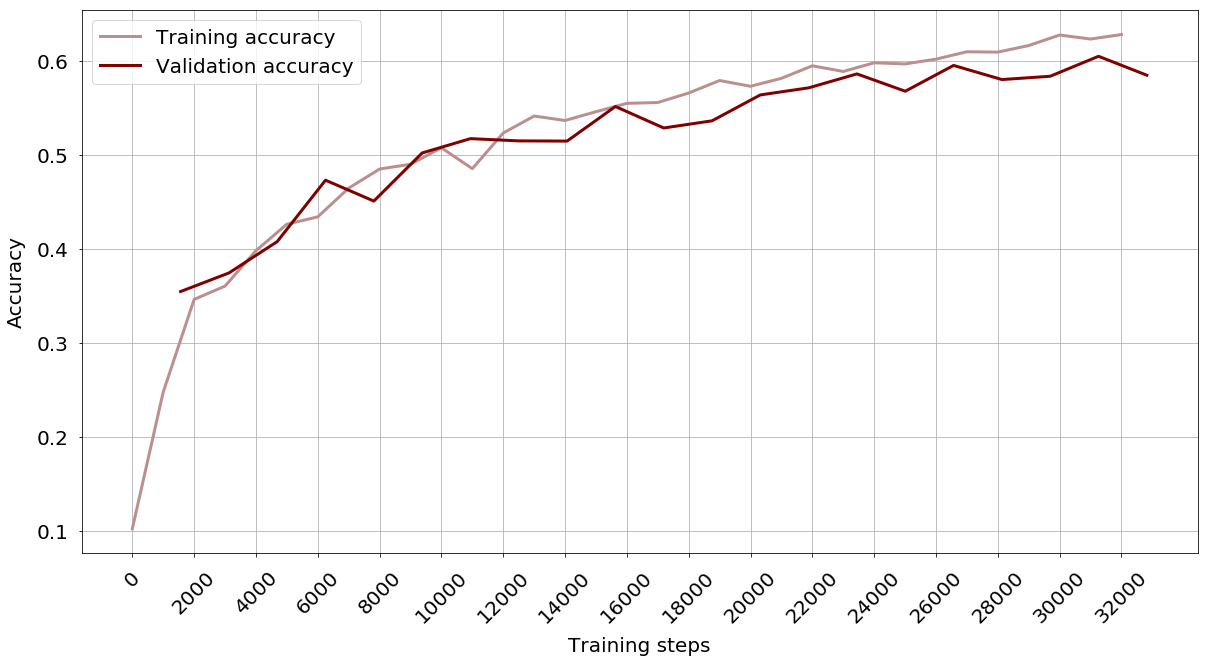

In [234]:
figure, axes = regu_16_history.plot_accuracy(
    data='both',
    figsize=(20,10),
    step_bounds_training=(None, None, 100),
    step_bounds_evaluation=(None, None, None),
    line_color_training='rosybrown',
    line_color_evaluation='maroon',
    line_width=3.0,
    x_ticks=(None, None, 200),
    x_ticks_rotation=45,
    tick_label_size=20,
    tick_label_pad=(10, 10),
    axis_label_size=20,
    axis_label_pad=(10, 10),
    axis_labels=['Training steps', 'Accuracy'],
    show_legend=True,
    legend_size=20,
    show_grid=True
)

In [235]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_16-filters_accuracy.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Regular 8

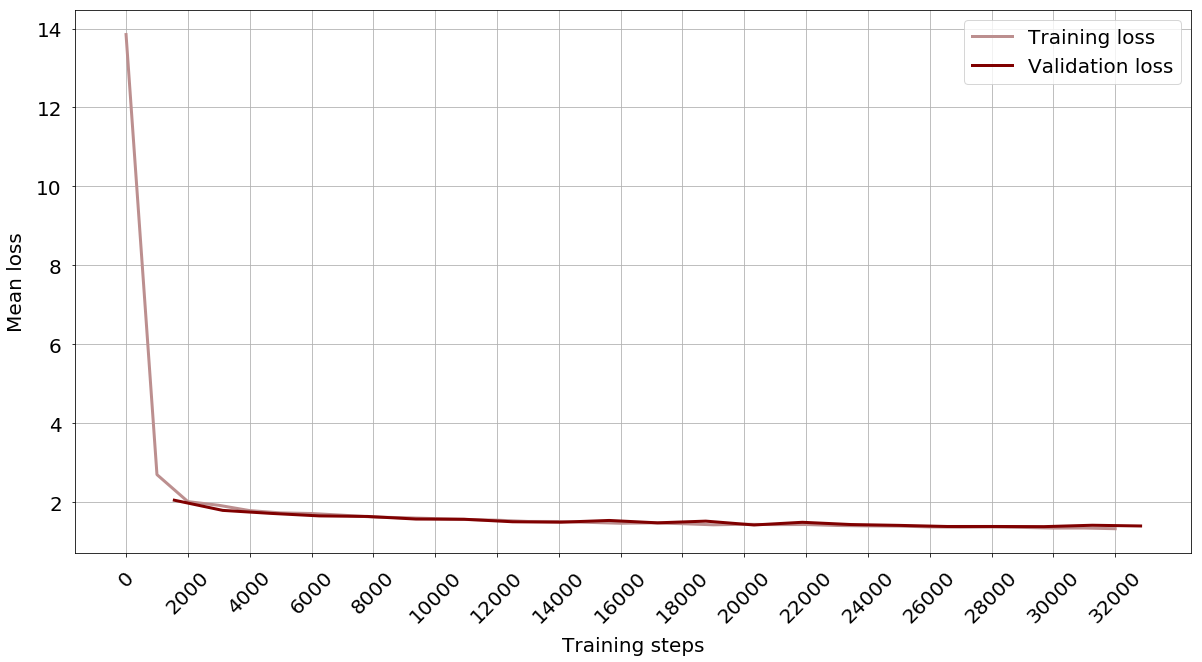

In [236]:
figure, axes = regu_8_history.plot_mean_loss(data='both',
                                              figsize=(20,10),
                                              step_bounds_training=(None, None, 100),
                                              step_bounds_evaluation=(None, None, None),
                                              line_color_training='rosybrown',
                                              line_color_evaluation='maroon',
                                              line_width=3.0,
                                              x_ticks=(None, None, 200),
                                              x_ticks_rotation=45,
                                              tick_label_size=20,
                                              tick_label_pad=(10, 10),
                                              axis_label_size=20,
                                              axis_label_pad=(10, 10),
                                              axis_labels=['Training steps', 'Mean loss'],
                                              show_legend=True,
                                              legend_size=20,
                                              show_grid=True)

In [237]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_8-filters_mean_loss.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

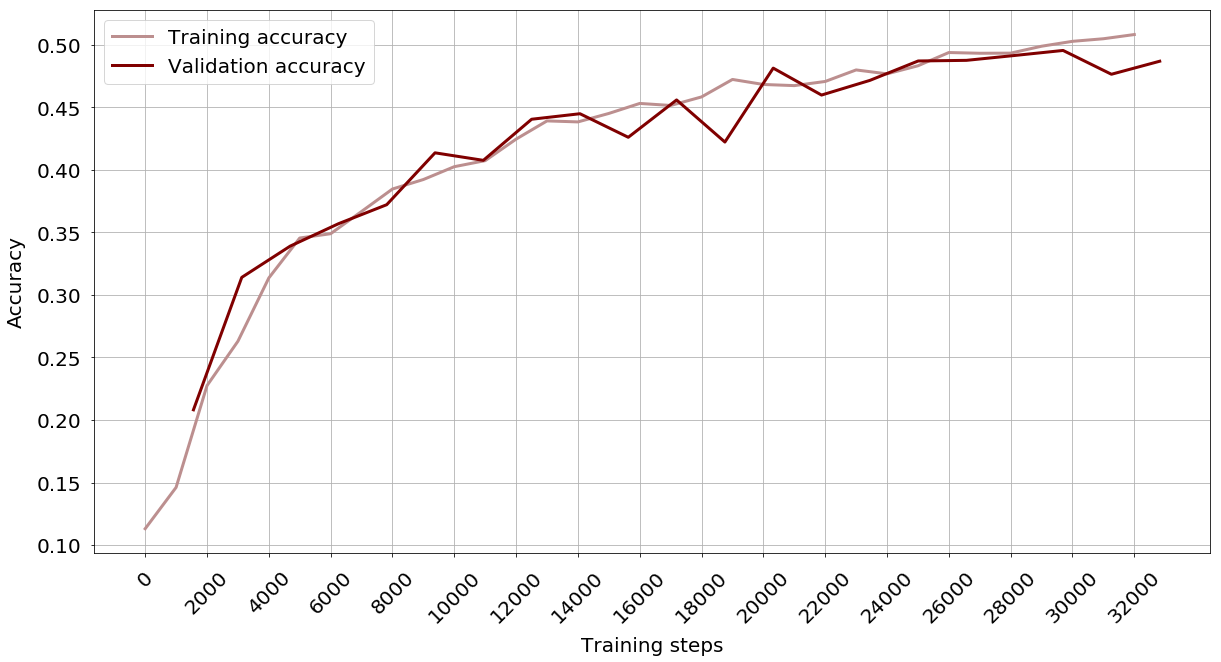

In [238]:
figure, axes = regu_8_history.plot_accuracy(
    data='both',
    figsize=(20,10),
    step_bounds_training=(None, None, 100),
    step_bounds_evaluation=(None, None, None),
    line_color_training='rosybrown',
    line_color_evaluation='maroon',
    line_width=3.0,
    x_ticks=(None, None, 200),
    x_ticks_rotation=45,
    tick_label_size=20,
    tick_label_pad=(10, 10),
    axis_label_size=20,
    axis_label_pad=(10, 10),
    axis_labels=['Training steps', 'Accuracy'],
    show_legend=True,
    legend_size=20,
    show_grid=True
)

In [239]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_8-filters_accuracy.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

# Gradient Norm Plots

## Antisymmetric 16

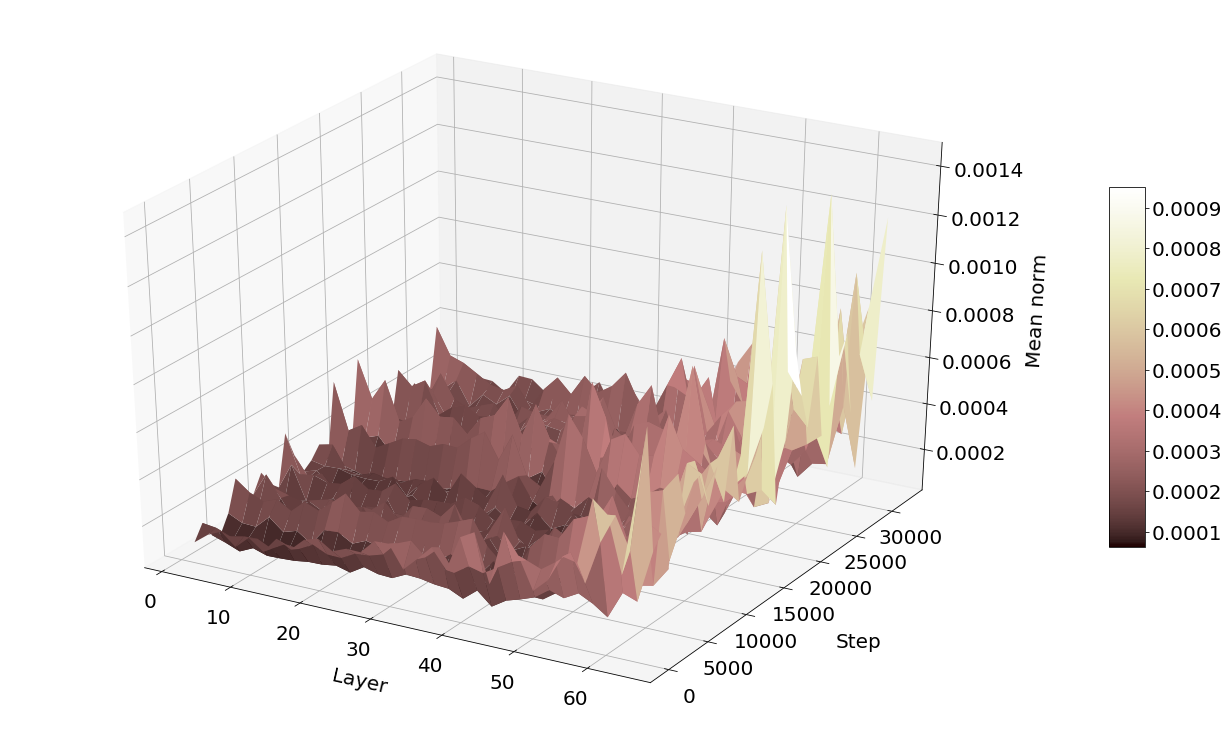

In [248]:
plot, axes, figure = anti_16_history.plot_gradient_norms(layer_bounds=(1, None, 2),
                                                         step_bounds=(3, None, 100),
                                                         z_axis_bounds=(None, None),
                                                         plot_type='surface',
                                                         figsize=(18, 10),
                                                         axis_labels=('Layer', 'Step', 'Mean norm'),
                                                         tick_label_font_size=20,
                                                         axis_label_font_size=20,
                                                         tick_label_pad=(10, 10, 20),
                                                         axis_label_pad=(18, 30, 22),
                                                         color_map=cm.pink,
                                                         color_bar=True,
                                                         color_bar_tick_label_size=20)

In [249]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_antisymmetric_64-layers_16-filters_gradient_norms.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Regular 16

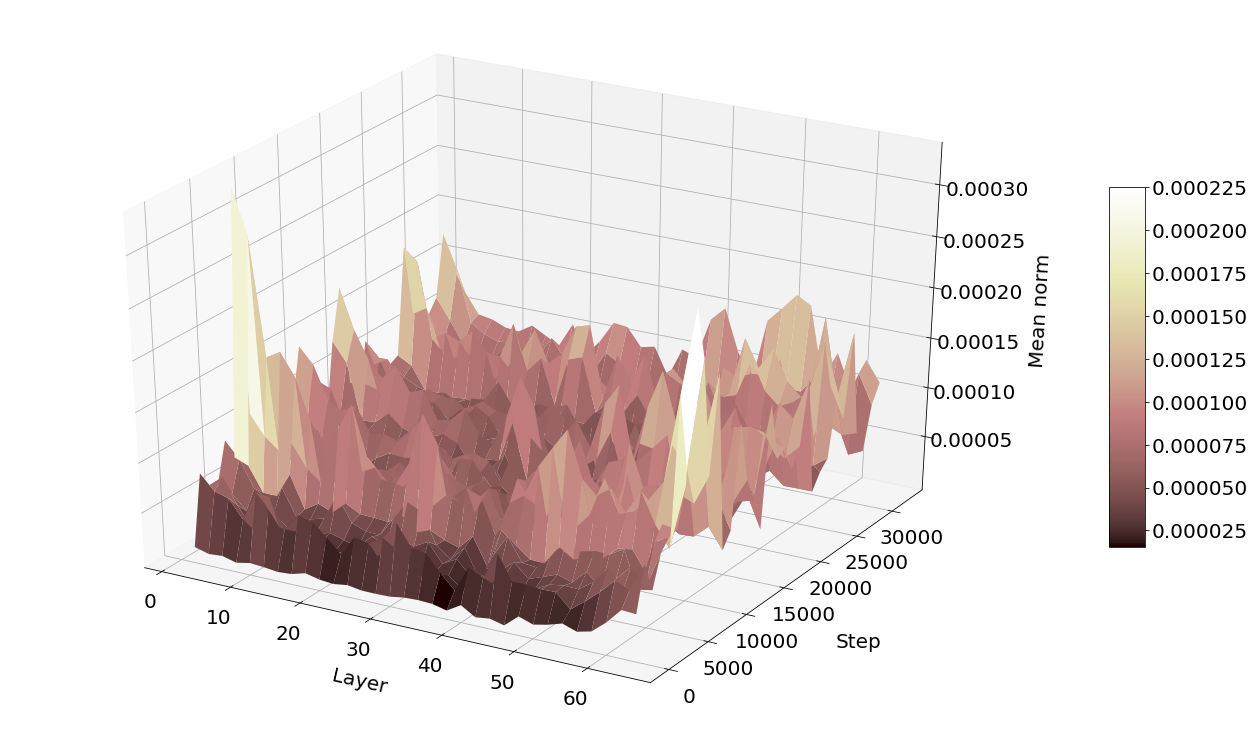

In [251]:
plot, axes, figure = regu_16_history.plot_gradient_norms(layer_bounds=(1, None, 2),
                                                         step_bounds=(1, None, 100),
                                                         z_axis_bounds=(None, None),
                                                         plot_type='surface',
                                                         figsize=(18, 10),
                                                         axis_labels=('Layer', 'Step', 'Mean norm'),
                                                         tick_label_font_size=20,
                                                         axis_label_font_size=20,
                                                         tick_label_pad=(10, 10, 20),
                                                         axis_label_pad=(18, 30, 24),
                                                         color_map=cm.pink,
                                                         color_bar=True,
                                                         color_bar_tick_label_size=20)

In [252]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_16-filters_gradient_norms.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)

## Regular 8

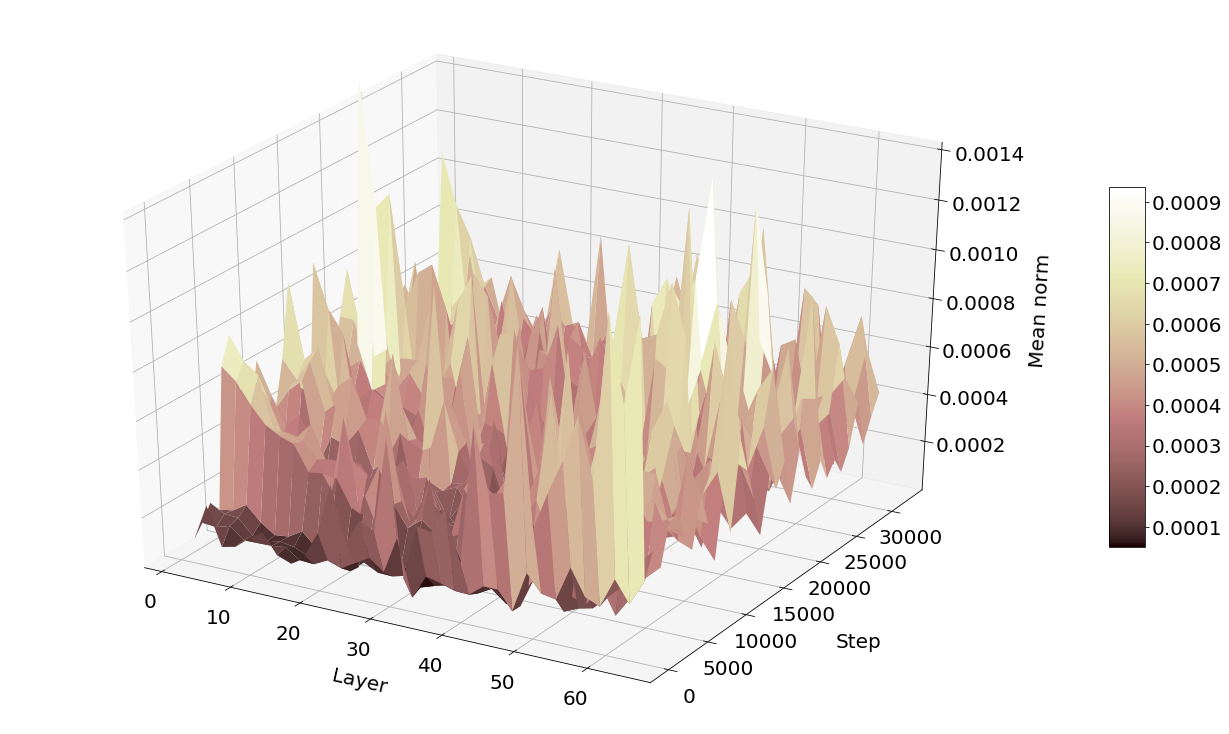

In [253]:
plot, axes, figure = regu_8_history.plot_gradient_norms(layer_bounds=(1, None, 2),
                                                        step_bounds=(5, None, 100),
                                                        z_axis_bounds=(None, 0.0014),
                                                        plot_type='surface',
                                                        figsize=(18, 10),
                                                        axis_labels=('Layer', 'Step', 'Mean norm'),
                                                        tick_label_font_size=20,
                                                        axis_label_font_size=20,
                                                        tick_label_pad=(10, 10, 20),
                                                        axis_label_pad=(18, 30, 24),
                                                        color_map=cm.pink,
                                                        color_bar=True,
                                                        color_bar_tick_label_size=20)

In [254]:
figure.savefig(fname='/pierluigiferrari/git/differential_equations_resnet/numerical_results/single_block_regular_64-layers_8-filters_gradient_norms.pdf',
               dpi=None,
               format='pdf',
               transparent=True,
               bbox_inches='tight',
               pad_inches=0.1)